In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from math import *

%matplotlib inline

In [40]:
def norm(df, col):
    max_v = df[col].max()
    min_v = df[col].min()
    df[col] = df[col].apply(lambda value: (value - min_v) / (max_v - min_v))

def T_star(x, p):
    def T(x, p):
        if p == 0:
            return 1
        elif p == 1:
            return x
        elif p == 2:
            return 2*x*x - 1
        elif p == 3:
            return 4*(x**3) - 3*x
        elif p == 4:
            return 8*(x**4)-8*(x**2) + 1
        elif p == 5:
            return 6*(x**5) - 20*(x**3) + 5*x
        else:
            return 2*x*T(x,p-1) - T(x, p-2)
    
    if p == 0:
        return 0.5
    return T(2*x-1, p)

def Psi(Lambda, x):
    m = x.shape[1]
    res = np.zeros([q0, m])
    for i in range(q0):
        for j in range(m):
            suma = 0.0
            for p in range(Lambda.shape[1]):
                suma += Lambda[j, p] * log(1 + _star(x[i, j], p))
            res[i, j] = exp(suma) - 1
    return res

def calc_A(psi, y):
    _y = np.log(y + 1)
    _psi = np.log(psi + 1)
    A1_temp, re, d, s = np.linalg.lstsq(_psi, _y)
    A1 = A1_temp.T
    return A1

def calc_c(a1, a2, a3, psi1, psi2, psi3, y, index):
    _y = np.log(y + 1)
    matrix1 = np.log(calc_Fi(a1, psi1, index)+1)
    matrix2 = np.log(calc_Fi(a2, psi2, index)+1)
    matrix3 = np.log(calc_Fi(a3, psi3, index)+1)

    matrix = np.concatenate((matrix1, matrix2, matrix3), axis=0).T
    y_c = _y[['y'+str(index+1)]].to_numpy()
    x, residuals, r, s = np.linalg.lstsq(matrix, y_c)
    return x

def calc_Fi(a, psi, index):
    res = []
    for i in range(0, len(psi)):
        suma = 0
        for j in range(0, len(psi[i])):             
            suma += a[index][j] *log(psi[i][j] + 1)
            res[i] = exp(suma) - 1
    return res


In [41]:
sample = pd.read_csv('vybirka-2.csv')

In [42]:
norm_sample = sample.copy()
for col in norm_sample.columns[1:]:
    norm(norm_sample, col)

In [43]:
p1 = 3
p2 = 3
p3 = 3

n1 = 2
n2 = 2
n3 = 3
q0 = 45

In [44]:
y = norm_sample[['y1', 'y2', 'y3', 'y4']]
y.head()

,y1,y2,y3,y4
0,0.362340,3.722023e-06,0.012578,0.000000
1,0.576367,1.479101e-06,0.052944,0.026370
2,1.000000,9.151350e-07,0.043941,0.058200
3,0.439406,1.430098e-06,0.064668,0.492081
4,0.337136,1.225713e-06,1.000000,0.898937


In [45]:
m = n1 * p1 + n2 * p2 + n3 * p3 + 1
matrix = np.zeros((q0, m))

temp = pd.DataFrame()
j = 0
for i in range(1, n1+1):
    for p in range(0, p1+1):
        temp.insert(j, f'T_{p}(x1{i}', norm_sample[f'x1{i}'].map(lambda x: T_star(x, p)))
        j+=1

for i in range(1, n2+1):
    for p in range(0, p2+1):
        temp.insert(j, f'T_{p}(x2{i}', norm_sample[f'x2{i}'].map(lambda x: T_star(x, p)))
        j+=1

for i in range(1, n3+1):
    for p in range(0, p3+1):
        temp.insert(j, f'T_{p}(x3{i}', norm_sample[f'x3{i}'].map(lambda x: T_star(x, p)))
        j+=1

biq0 = (norm_sample[['y1', 'y2', 'y3','y4']].max(axis=1) + norm_sample[['y1', 'y2', 'y3','y4']].min(axis=1)) / 2
biq0T = np.array([biq0.to_numpy()]).T
x, residuals, r, s = np.linalg.lstsq(temp, biq0T)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [46]:
L = x.T[0]
cols = temp.columns
end1 = n1*(p1+1)
end2 = end1 + n2*(p2+1)
lambda1_f = x[:n1*(p1+1)].T[0]
temp.loc[:, cols[:n1*(p1+1)]] *= lambda1_f
lambda1 = np.reshape(x[:n1*(p1+1)], (n1, p1+1))
lambda2_f = x[end1:end2].T[0]
lambda2 = np.reshape(x[end1:end2], (n2, p2+1))
temp.loc[:, cols[end1:end2]] *= lambda2_f
lambda3_f = x[end2:].T[0]
lambda3 = np.reshape(x[end2:], (n3, p3+1))
temp.loc[:, cols[end2:]] *= lambda3_f

In [47]:
print(f"lambda_1 \n{lambda1}\n")
print(f"lambda_2 \n{lambda2}\n")
print(f"lambda_3 \n{lambda3}")

lambda_1 
[[-4.89966910e+12  1.57617853e+13 -1.72223352e+13 -1.12231283e+13]
 [ 1.09079747e+13  1.52000677e+13  4.18821209e+13  6.74337519e+11]]

lambda_2 
[[ 3.23542406e+12  4.93612821e+13 -1.54594194e+13 -4.07807196e+12]
 [-4.17633894e+11  8.24161892e+12  4.38093916e+13  2.99779667e+13]]

lambda_3 
[[-4.17633894e+11  2.10509090e+13 -4.18661598e+13  1.55323919e+13]
 [-4.17633894e+11  5.37489318e+13  5.71486743e+12 -2.53835961e+13]
 [-4.17633894e+11  9.87991799e+12  3.58915874e+12 -5.49989984e+12]]


In [48]:
df_psi = pd.DataFrame()
j = 0
for i in range(1, n1+1):
    init = temp[f'T_{0}(x1{i}']
    for p in range(1, p1+1):
        init = init.add(temp[f'T_{p}(x1{i}'])
    df_psi.insert(j, f'psi_x1{i}', init)
    j+=1

for i in range(1, n2+1):
    init = temp[f'T_{0}(x2{i}']
    for p in range(1, p2+1):
        init = init.add(temp[f'T_{p}(x2{i}'])
    df_psi.insert(j, f'psi_x2{i}', init)
    j+=1

for i in range(1, n3+1):
    init = temp[f'T_{0}(x3{i}']
    for p in range(1, p3+1):
        init = init.add(temp[f'T_{p}(x3{i}'])
    df_psi.insert(j, f'psi_x3{i}', init)
    j+=1
df_psi.head()

,psi_x11,psi_x12,psi_x21,psi_x22,psi_x31,psi_x32,psi_x33
0,-2.421083e+13,2.726118e+12,-2.388841e+13,-1.149321e+13,4.337686e+13,8.511447e+12,4.978021e+12
1,-2.338860e+13,-1.835807e+13,-6.285969e+12,-3.402406e+13,3.787036e+13,3.488566e+13,9.300675e+12
2,-1.562271e+13,-3.161325e+13,9.873849e+12,-5.184893e+13,2.613942e+13,5.236065e+13,1.071097e+13
3,-3.869056e+12,-3.686182e+13,2.351699e+13,-5.707237e+13,1.227488e+13,5.425102e+13,7.760360e+12
4,8.916487e+12,-3.392619e+13,3.356938e+13,-4.179896e+13,3.675699e+11,3.387139e+13,-9.996764e+11


In [49]:
psi_1n = [f'psi_x1{i}' for i in range(1, n1+1)]
a1, res, r, s = np.linalg.lstsq(df_psi[psi_1n], y)
a1 = a1.T
psi_2n = [f'psi_x2{i}' for i in range(1, n2+1)]
a2, res, r, s = np.linalg.lstsq(df_psi[psi_2n], y)
a2 = a2.T
psi_3n = [f'psi_x3{i}' for i in range(1, n3+1)]
a3, res, r, s = np.linalg.lstsq(df_psi[psi_3n], y)
a3 = a3.T

print(f"a_1 \n{a1}\n")
print(f"a_2 \n{a2}\n")
print(f"a_3 \n{a3}")

a_1 
[[-1.93639155e-15 -3.39078578e-15]
 [-8.23607500e-18 -1.22508319e-15]
 [ 5.57618171e-15 -2.58126270e-15]
 [ 4.47379930e-15 -3.96256758e-15]]

a_2 
[[ 2.32009092e-15 -3.62445445e-15]
 [ 6.09088435e-16 -1.16209634e-15]
 [ 2.79925284e-15 -9.07337987e-16]
 [ 3.59046078e-15 -2.73413319e-15]]

a_3 
[[ 4.88469393e-15  6.30145336e-15 -3.49801605e-14]
 [ 1.00159445e-17  2.13452124e-15 -5.85336016e-15]
 [ 4.39715702e-15  1.15009463e-14 -7.29920975e-14]
 [ 3.00638465e-15  1.11358165e-14 -5.92563987e-14]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond

In [50]:
df_psi1 = df_psi[psi_1n].copy()
df_psi2 = df_psi[psi_2n].copy()
df_psi3 = df_psi[psi_3n].copy()

df_psi1.head()

,psi_x11,psi_x12
0,-2.421083e+13,2.726118e+12
1,-2.338860e+13,-1.835807e+13
2,-1.562271e+13,-3.161325e+13
3,-3.869056e+12,-3.686182e+13
4,8.916487e+12,-3.392619e+13


In [51]:
f1 = (df_psi1 * a1[0]).sum(axis=1)
f2 = (df_psi2 * a2[1]).sum(axis=1)
f3 = (df_psi3 * a3[2]).sum(axis=1)
df_f = pd.DataFrame()
df_f.insert(0, 'f1', f1)
df_f.insert(1, 'f2', f2)
df_f.insert(2, 'f3', f3)

In [52]:
def calc_dfc(a1, a2, a3, df_psi1, df_psi2, df_psi3, y, index):
    res = pd.DataFrame()
    res.insert(0, 'f1i', (df_psi1 * a1[index]).sum(axis=1))
    res.insert(1, 'f2i', (df_psi2 * a2[index]).sum(axis=1))
    res.insert(2, 'f3i', (df_psi3 * a3[index]).sum(axis=1))
    x, res, r, s = np.linalg.lstsq(res, y[f'y{index+1}'])
    return x

arr = np.array([calc_dfc(a1, a2, a3, df_psi1, df_psi2, df_psi3, y, index) for index in range(4)])

print(f"Matrix C:\n{arr}\n")

for i in range(len(arr)):
    s = f"Ф{i+1}(x1,x2,x3) = exp{{"
    for j in range(len(arr[i])):
        s += f"({arr[i, j]})*ln(1+Ф{i+1}{j+1}(x{j+1}))"
        if(j != len(arr[i]) - 1):
            s+= " + "
    s+="}"
    print(s)

Matrix C:
[[-0.15466974  0.83897921  0.4286599 ]
 [-0.46257756  0.76895154  0.61605473]
 [-0.20435446  0.12179931  1.04236155]
 [-0.27459     0.60307815  0.75449241]]

Ф1(x1,x2,x3) = exp{(-0.1546697416940388)*ln(1+Ф11(x1)) + (0.8389792086698625)*ln(1+Ф12(x2)) + (0.42865990261251247)*ln(1+Ф13(x3))}
Ф2(x1,x2,x3) = exp{(-0.4625775624248519)*ln(1+Ф21(x1)) + (0.7689515445760858)*ln(1+Ф22(x2)) + (0.6160547275487607)*ln(1+Ф23(x3))}
Ф3(x1,x2,x3) = exp{(-0.20435446327123702)*ln(1+Ф31(x1)) + (0.12179931319145693)*ln(1+Ф32(x2)) + (1.0423615478199804)*ln(1+Ф33(x3))}
Ф4(x1,x2,x3) = exp{(-0.2745899970169465)*ln(1+Ф41(x1)) + (0.6030781471013267)*ln(1+Ф42(x2)) + (0.7544924086647117)*ln(1+Ф43(x3))}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


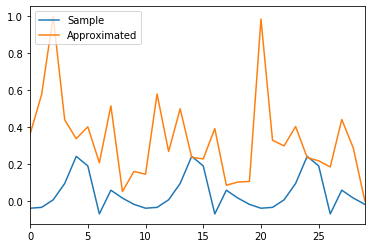

Max_error_Y1 = 1.023482983946815


In [53]:
t = pd.DataFrame({f'{i}': (df_f * arr[i]).sum(axis=1) for i in range(4)})
t['0'].plot.line(label='Sample')
y['y1'].plot.line(label='Approximated')
plt.legend(loc='upper left')
plt.show()

r = (t['0'] - y['y1']).apply(abs)
print(f"Max_error_Y1 = {r.max()}")

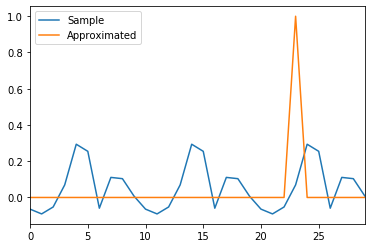

Max_error_Y2 = 0.9305992153483174


In [54]:
t['1'].plot.line(label='Sample')
y['y2'].plot.line(label='Approximated')
plt.legend(loc='upper left')
plt.show()

r = (t['1'] - y['y2']).apply(abs)
print(f"Max_error_Y2 = {r.max()}")

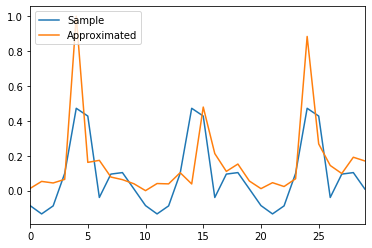

Max_error_Y3 = 0.5277738175728851


In [55]:
t['2'].plot.line(label='Sample')
y['y3'].plot.line(label='Approximated')
plt.legend(loc='upper left')
plt.show()

r = (t['2'] - y['y3']).apply(abs)
print(f"Max_error_Y3 = {r.max()}")

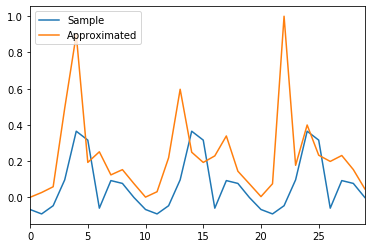

Max_error_Y4 = 1.0465770220473924


In [56]:
t['3'].plot.line(label='Sample')
y['y4'].plot.line(label='Approximated')
plt.legend(loc='upper left')
plt.show()

r = (t['3'] - y['y4']).apply(abs)
print(f"Max_error_Y4 = {r.max()}")

In [38]:
x1 = norm_sample[['x11', 'x12']].to_numpy()
x2 = norm_sample[['x21', 'x22']].to_numpy()
x3 = norm_sample[['x31', 'x32', 'x33']].to_numpy()

In [3]:
# pip install pandas --upgrade

  Using cached https://files.pythonhosted.org/packages/74/8c/9cf2e5304f4466dbc759a799b97bfd75cd3dc93b00d49558ca93bfc29173/pandas-1.2.4-cp37-cp37m-win_amd64.whl
  Found existing installation: pandas 0.25.1
    Uninstalling pandas-0.25.1:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\pandas-0.25.1.dist-info\\entry_points.txt'
Consider using the `--user` option or check the permissions.



In [4]:
# pip install iexfinance --upgrade

Requirement already up-to-date: iexfinance in c:\programdata\anaconda3\lib\site-packages (0.5.0)
Note: you may need to restart the kernel to use updated packages.
